In [4]:
# -*- coding: utf-8 -*-

'''
This code is based on particle filter research includning, particularly, these two articles:
    * Fox, D., Burgard, W., Dellaert, F., & Thrun, S. (1999). Monte carlo localization: Efficient position 
      estimation for mobile robots. AAAI/IAAI, 1999(343-349), 2-2.
    * F. Dellaert, D. Fox, W. Burgard and S. Thrun, "Monte Carlo localization for mobile robots," 
      Proceedings 1999 IEEE International Conference on Robotics and Automation (Cat. No.99CH36288C), 
      1999, pp. 1322-1328 vol.2, doi: 10.1109/ROBOT.1999.772544.
    
Robots and particles derived from the robot class have these features:
    * Constant noise in movement distance and heading expressed as a percentage 
      of the nominal movement distance and direction, respectively
    * Constant noise in sensing distance to the navigation features as a constant 
      percentage of the domain dimension
    * A copy method to permit avoidance of alaising
    * In-place movement: robot x and y coordinates are updated in place rather than needing to 
      instantiate a new robot
    
Distance to navigation features is computed as the Euclidean distance.

Resampling weights for particles are computed via rank of sum of squared differences in distances to navigation
  features robot versus particles

'''

from math import *
import random
import matplotlib.pyplot as plt
import numpy as np

nav_features  = [[10.0, 10.0], [80.0, 90.0], [20.0, 70.0], [90.0, 20.0]]
domain_size = 100.0

class robot:
    ''' Initialize robot with random location/orientation and movement & sensing noise '''
    def __init__(self, forward_noise, turn_noise, sense_noise):
        self.x = random.random() * domain_size
        self.y = random.random() * domain_size
        self.heading = random.random() * 2.0 * pi
        self.forward_noise = float(forward_noise);
        self.turn_noise    = float(turn_noise);
        self.sense_noise   = float(sense_noise);
    
    ''' Measure distance to navigation features, with noise '''
    def sense(self):
        Z = []
        for i in range(len(nav_features)):
            dist = sqrt((self.x - nav_features[i][0]) ** 2 + (self.y - nav_features[i][1]) ** 2)
            dist += (random.random() - 1) * domain_size * self.sense_noise 
            Z.append(dist)
        return Z
    
    ''' Execute move and change location and orientation in-place '''
    def move(self, forward, delta_heading):
        # Update heading with noise
        self.heading = (self.heading + float(delta_heading) * (1 + random.random() - 1) * self.turn_noise) % 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) * (1 + (random.random() - 1) * self.forward_noise) 
        self.x = (self.x + (cos(self.heading) * dist)) % domain_size
        self.y = (self.y + (sin(self.heading) * dist)) % domain_size
    
    ''' Compute sum of squared differences between robot and particle distances to navigation features '''
    def dist_measure(self, robot_meas):
        dist = 0.0;
        me_Z = self.sense()
        for i in range(len(nav_features)):
            dist += (me_Z[i] - robot_meas[i]) ** 2
        return dist 
    
    def copy(self):
        myrobot = robot(self.forward_noise, self.turn_noise, self.sense_noise)
        myrobot.x = self.x
        myrobot.y = self.y
        myrobot.heading = self.heading
        return myrobot
        
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.heading))

def compute_prob(particle_weights):
    ranks = np.empty((len(particle_weights),))
    ranks[np.argsort(-np.array(particle_weights))] = np.arange(len(particle_weights))
    ranks += 1
    w = len(particle_weights) * (len(particle_weights) + 1) / 2 
    return ranks / w
        
    
def plot_domain(t, robot, particles):
    fig,ax = plt.subplots()
    ax.scatter([x.x for x in particles], [x.y for x in particles], c='k', alpha=0.15, zorder=0) #
    #ax.plot([myrobot.x], [myrobot.y], marker='o', color='r', markersize=6, zorder=1)
    ax.scatter([robot.x], [robot.y], c='r', zorder=1)
    ax.set_xlim(0,domain_size)
    ax.set_ylim(0,domain_size)
    fig.suptitle('Iteration ' + str(t))
    fig.set_size_inches(6,6)
    plt.show()

In [5]:
''' Parameters '''
num_particles = 2000        # Number of particles in filter
num_iterations = 50          # Number of robot moves to make
move_dist = 5.0  # magnitude of random movement 
move_heading = 0.5 # magnitude of random turn direction
noise_args = (0.05, 0.05, 0.00005)  # noise arguments for movement magnitude, movement direction, and sensing distance to navigation features

''' Create robot to be localized '''
'''   The arguments define, in sequence, the noise in movement magnitude, movement direction, and
      noise is sensing.  The particles used to estimate the robot's position should have the same 
      noise parameters '''
myrobot = robot(*noise_args)

''' Create collection of N particles '''
p = [robot(*noise_args) for i in range(num_particles)]
p[0].sense()

9237.690875544282


In [16]:
for t in range(1,3):
    move_args = (move_dist*random.random(), move_heading*random.random())
    myrobot.move(*move_args)
    myrobot_features_dist = myrobot.sense()
    for i in p:
        i.move(*move_args)
        i_features_dist = i.sense()
    #print(i.x)
    #print("bot:",myrobot)
    d = []
    for i in p:
        d.append(myrobot.dist_measure(i.sense()))
    #print("d1:",d[0:3])
    d = compute_prob(d)
    (random.random()+np.arange(num_particles))/num_particles
    indexes = np.zeros(20,'i')
    cum = np.cumsum(d)
    i,j = 0,0
    #while i < n:
    #    if indexes[i] < p

In [12]:
d_sum = np.cumsum(d)
d_c = d_sum.copy()
d_c.sort
print(d_sum==d_c)
p_new = []
urv_list = [random.uniform(0,1) for i in range(num_particles)]
urv_list.sort()
#print(type(urv_list))
i,j = 0,0
for i in urv_list:
    idx = (np.abs(d_sum-i)).argmin() #d_sum's index for i probability,np.abs(d_sum-i)
    #print(np.abs(d_sum-i),idx)
    if d_sum[idx] >= i:# probability i is less or equal to the culmulative probability 
        p_new.append(p[idx].copy()) #choose the particle
    else:
        p_new.append(p[idx-1].copy()) #if i is more than the culmulative prob, 
        #add particle with one index less than the current index 

NameError: name 'd' is not defined

array([0.02496199, 0.07496199, 0.12496199, 0.17496199, 0.22496199,
       0.27496199, 0.32496199, 0.37496199, 0.42496199, 0.47496199,
       0.52496199, 0.57496199, 0.62496199, 0.67496199, 0.72496199,
       0.77496199, 0.82496199, 0.87496199, 0.92496199, 0.97496199])

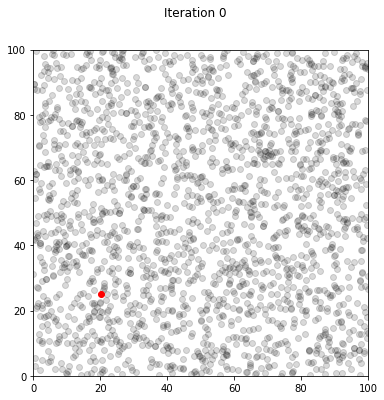


Iteration 1


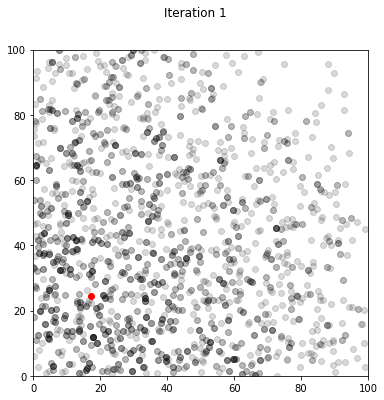


Iteration 2


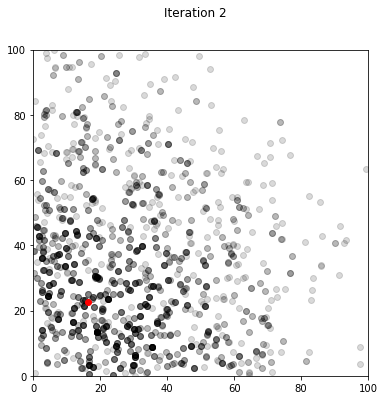


Iteration 3


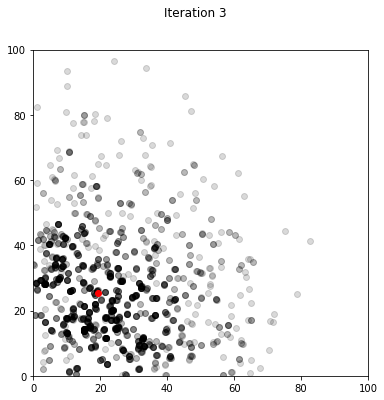


Iteration 4


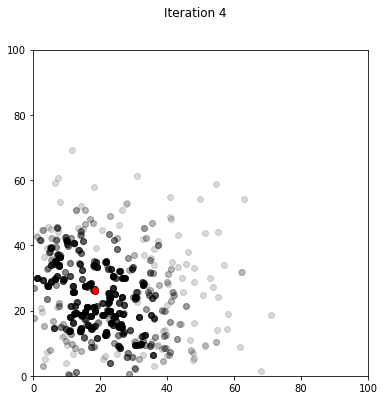


Iteration 5


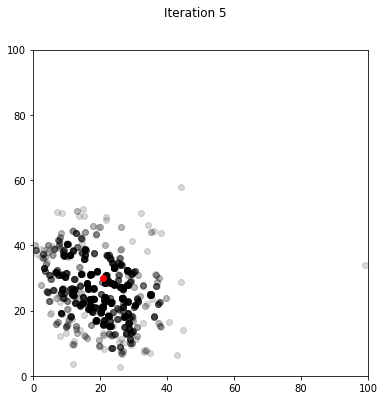


Iteration 6


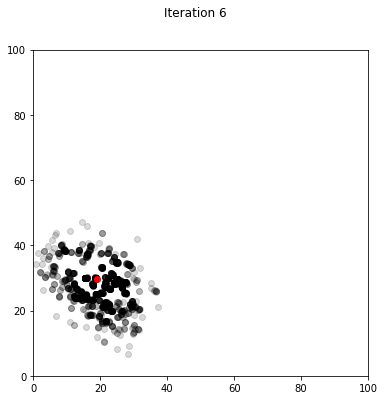


Iteration 7


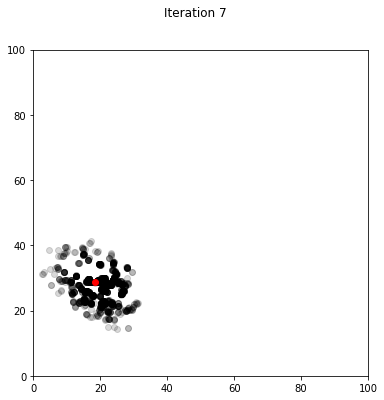


Iteration 8


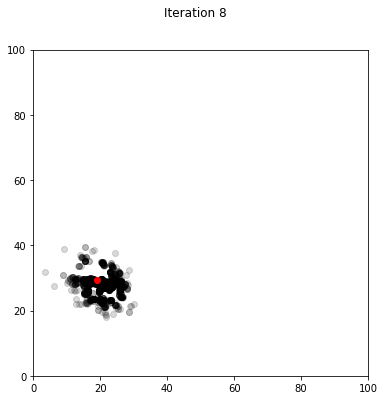


Iteration 9


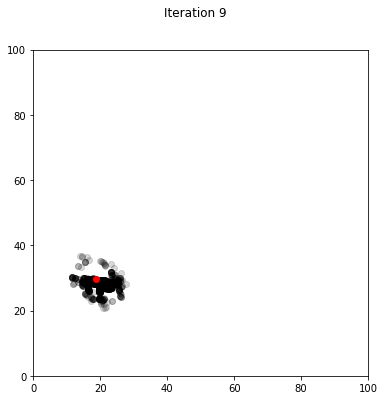


Iteration 10


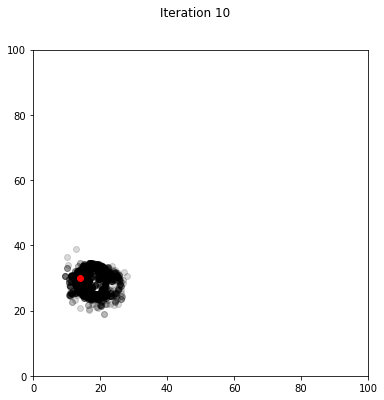


Iteration 11


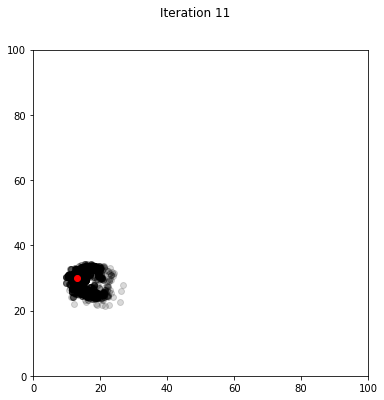


Iteration 12


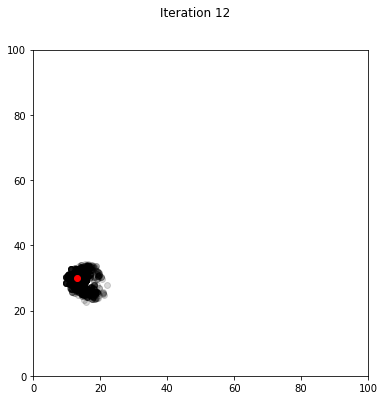


Iteration 13


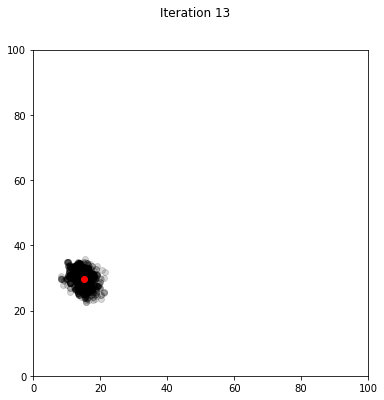


Iteration 14


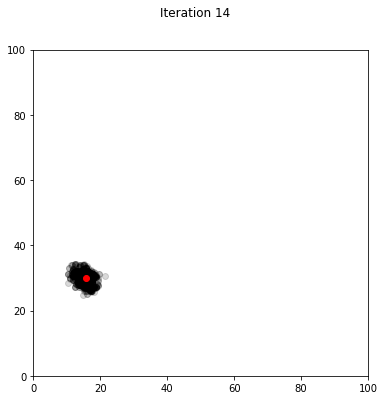


Iteration 15


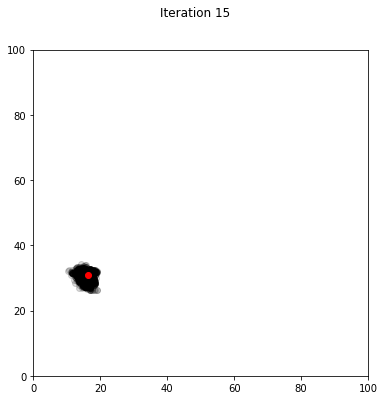


Iteration 16


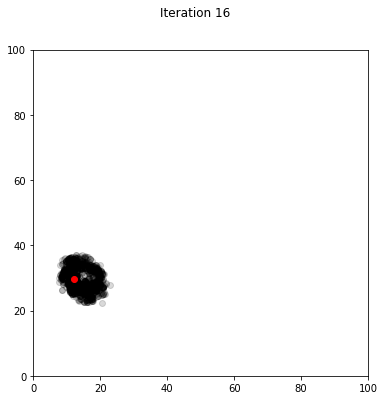


Iteration 17


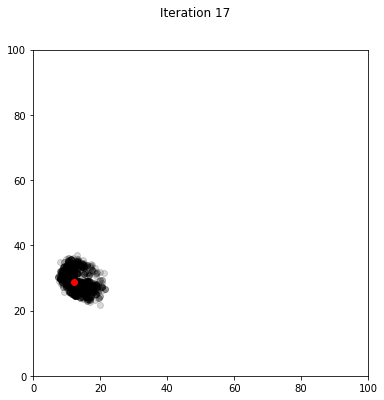


Iteration 18


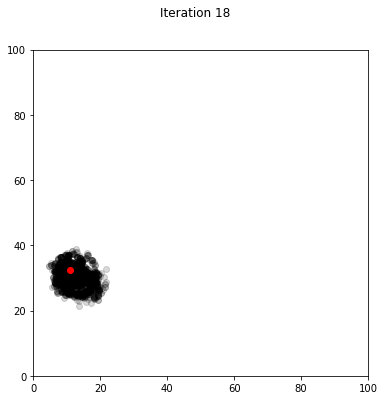


Iteration 19


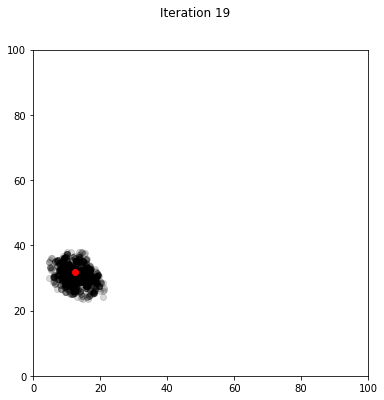


Iteration 20


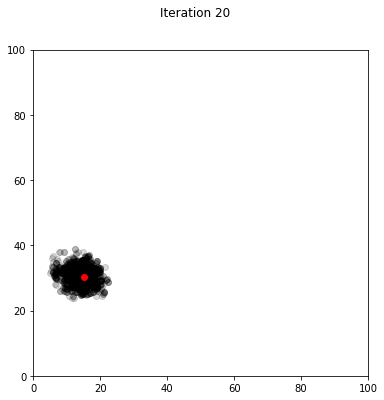


Iteration 21


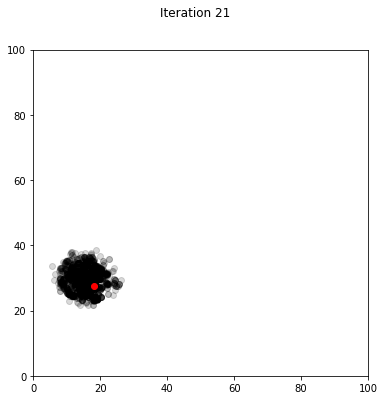


Iteration 22


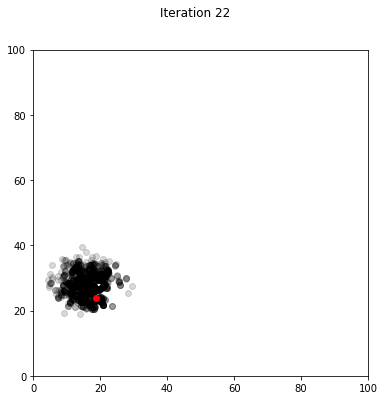


Iteration 23


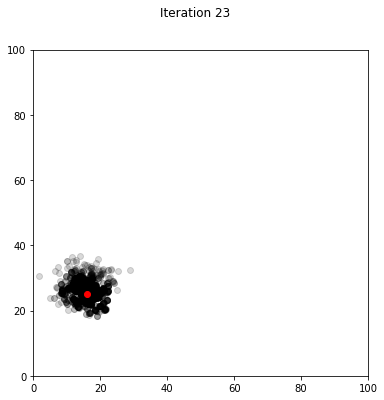


Iteration 24


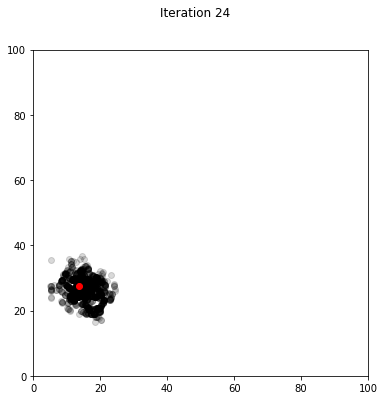


Iteration 25


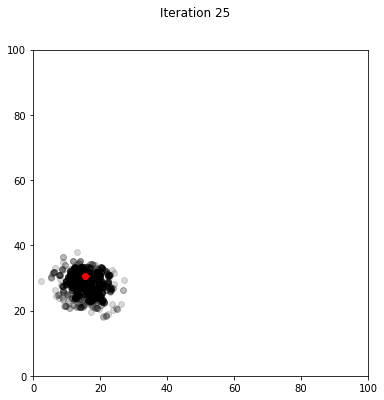


Iteration 26


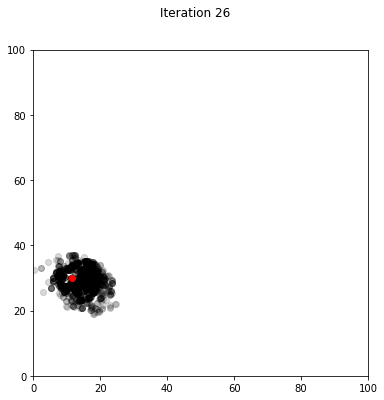


Iteration 27


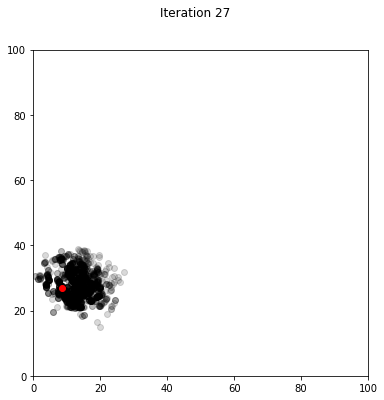


Iteration 28


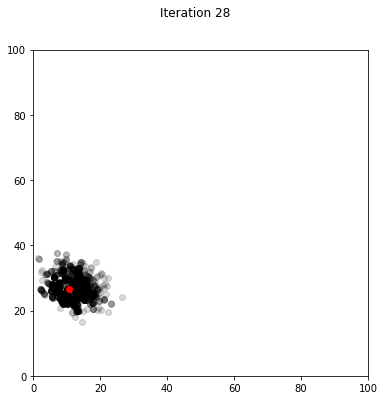


Iteration 29


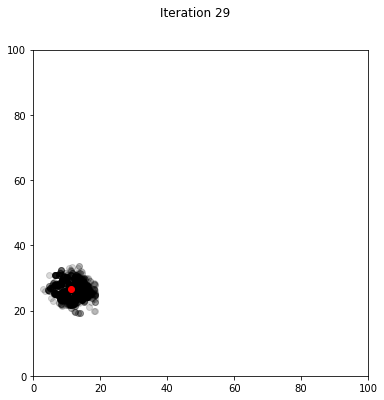


Iteration 30


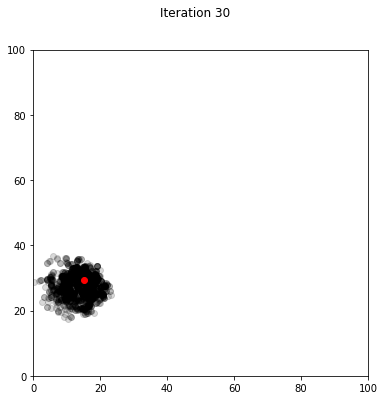


Iteration 31


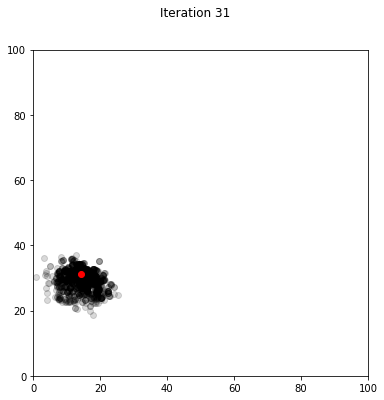


Iteration 32


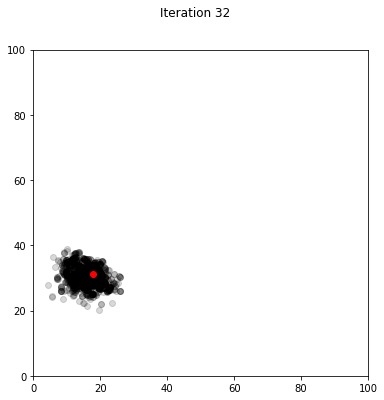


Iteration 33


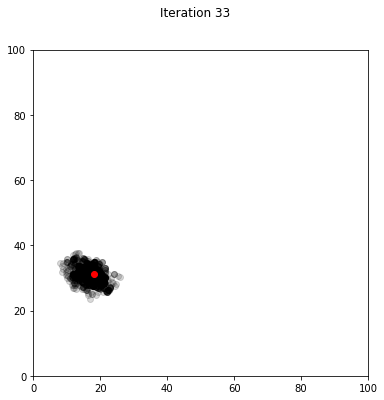


Iteration 34


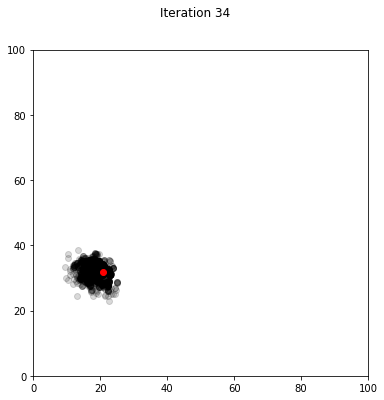


Iteration 35


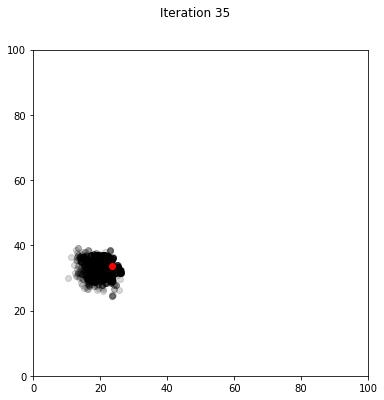


Iteration 36


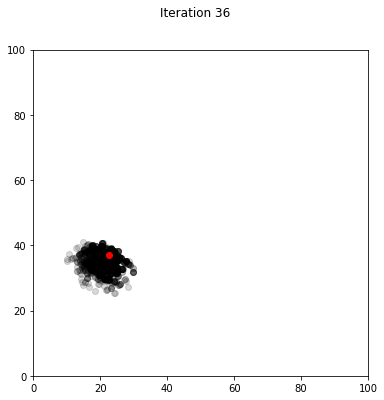


Iteration 37


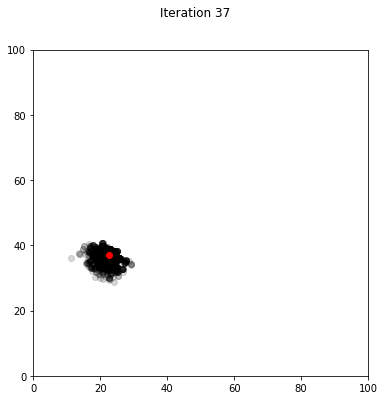


Iteration 38


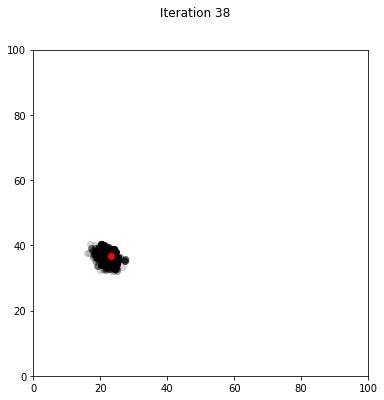


Iteration 39


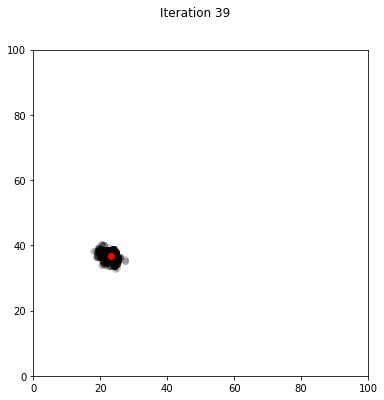


Iteration 40


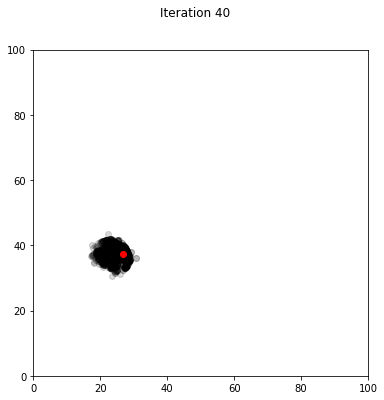


Iteration 41


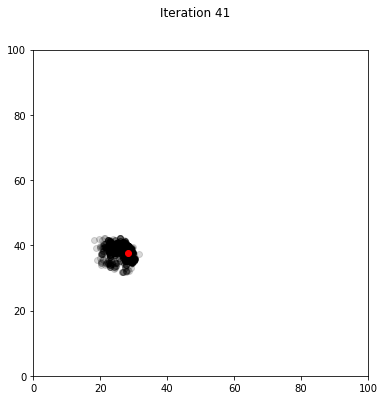


Iteration 42


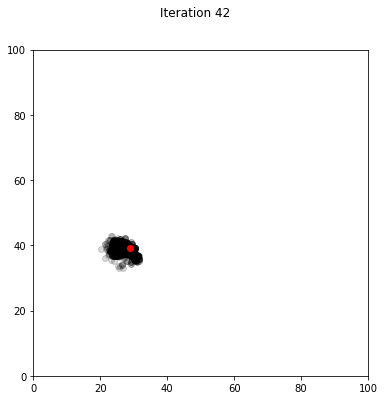


Iteration 43


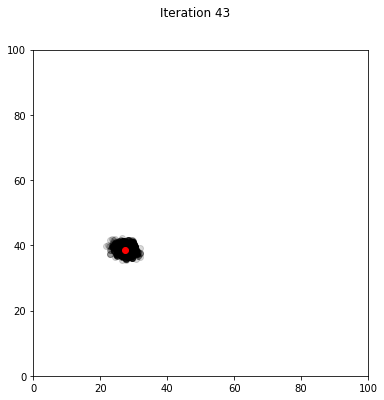


Iteration 44


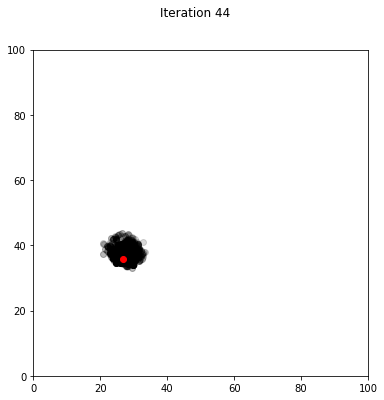


Iteration 45


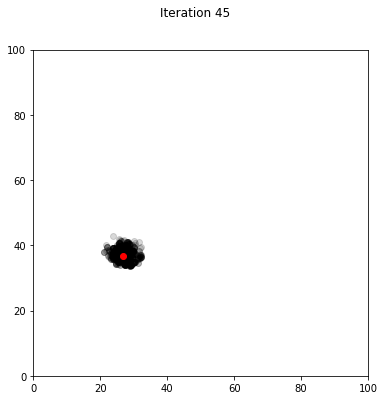


Iteration 46


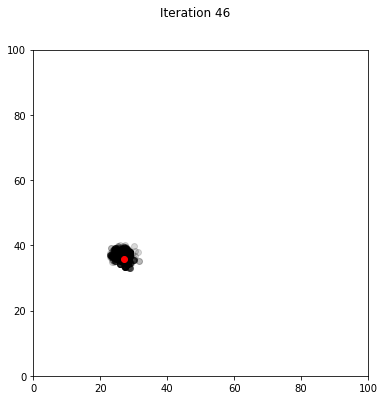


Iteration 47


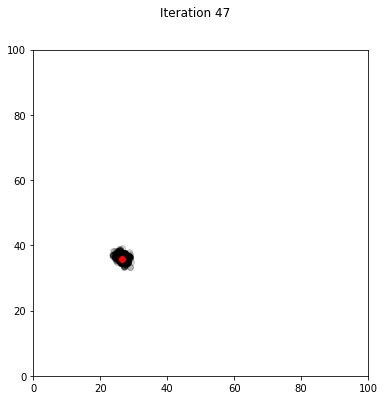


Iteration 48


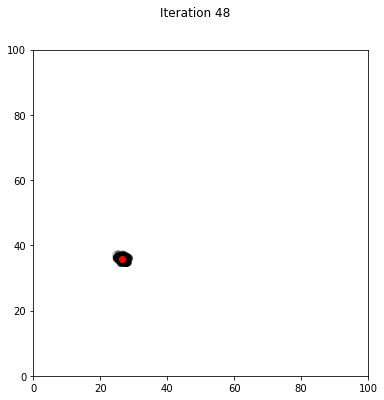


Iteration 49


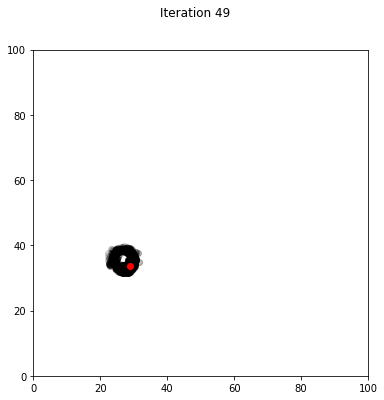


Iteration 50


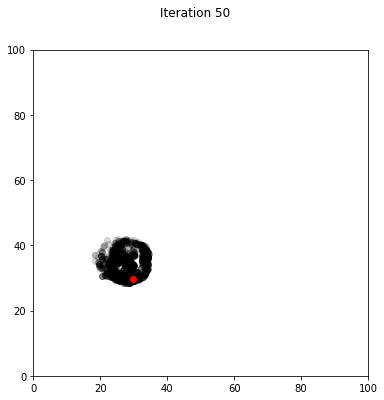

In [4]:
# -*- coding: utf-8 -*-

'''
This code is based on particle filter research includning, particularly, these two articles:
    * Fox, D., Burgard, W., Dellaert, F., & Thrun, S. (1999). Monte carlo localization: Efficient position 
      estimation for mobile robots. AAAI/IAAI, 1999(343-349), 2-2.
    * F. Dellaert, D. Fox, W. Burgard and S. Thrun, "Monte Carlo localization for mobile robots," 
      Proceedings 1999 IEEE International Conference on Robotics and Automation (Cat. No.99CH36288C), 
      1999, pp. 1322-1328 vol.2, doi: 10.1109/ROBOT.1999.772544.
    
Robots and particles derived from the robot class have these features:
    * Constant noise in movement distance and heading expressed as a percentage 
      of the nominal movement distance and direction, respectively
    * Constant noise in sensing distance to the navigation features as a constant 
      percentage of the domain dimension
    * A copy method to permit avoidance of alaising
    * In-place movement: robot x and y coordinates are updated in place rather than needing to 
      instantiate a new robot
    
Distance to navigation features is computed as the Euclidean distance.

Resampling weights for particles are computed via rank of sum of squared differences in distances to navigation
  features robot versus particles

'''

from math import *
import random
import matplotlib.pyplot as plt
import numpy as np

nav_features  = [[10.0, 10.0], [80.0, 90.0], [20.0, 70.0], [90.0, 20.0]]
domain_size = 100.0

class robot:
    ''' Initialize robot with random location/orientation and movement & sensing noise '''
    def __init__(self, forward_noise, turn_noise, sense_noise):
        self.x = random.random() * domain_size
        self.y = random.random() * domain_size
        self.heading = random.random() * 2.0 * pi
        self.forward_noise = float(forward_noise);
        self.turn_noise    = float(turn_noise);
        self.sense_noise   = float(sense_noise);
    
    ''' Measure distance to navigation features, with noise '''
    def sense(self):
        Z = []
        for i in range(len(nav_features)):
            dist = sqrt((self.x - nav_features[i][0]) ** 2 + (self.y - nav_features[i][1]) ** 2)
            dist += (random.random() - 1) * domain_size * self.sense_noise 
            Z.append(dist)
        return Z
    
    ''' Execute move and change location and orientation in-place '''
    def move(self, forward, delta_heading):
        # Update heading with noise
        self.heading = (self.heading + float(delta_heading) * (1 + random.random() - 1) * self.turn_noise) % 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) * (1 + (random.random() - 1) * self.forward_noise) 
        self.x = (self.x + (cos(self.heading) * dist)) % domain_size
        self.y = (self.y + (sin(self.heading) * dist)) % domain_size
    
    ''' Compute sum of squared differences between robot and particle distances to navigation features '''
    def dist_measure(self, robot_meas):
        dist = 0.0;
        me_Z = self.sense()
        for i in range(len(nav_features)):
            dist += (me_Z[i] - robot_meas[i]) ** 2
        return dist 
    
    def copy(self):
        myrobot = robot(self.forward_noise, self.turn_noise, self.sense_noise)
        myrobot.x = self.x
        myrobot.y = self.y
        myrobot.heading = self.heading
        return myrobot
        
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.heading))

def compute_prob(particle_weights):
    ranks = np.empty((len(particle_weights),))
    ranks[np.argsort(-np.array(particle_weights))] = np.arange(len(particle_weights))
    ranks += 1
    w = len(particle_weights) * (len(particle_weights) + 1) / 2 
    return ranks / w
        
    
def plot_domain(t, robot, particles):
    fig,ax = plt.subplots()
    ax.scatter([x.x for x in particles], [x.y for x in particles], c='k', alpha=0.15, zorder=0) #
    #ax.plot([myrobot.x], [myrobot.y], marker='o', color='r', markersize=6, zorder=1)
    ax.scatter([robot.x], [robot.y], c='r', zorder=1)
    ax.set_xlim(0,domain_size)
    ax.set_ylim(0,domain_size)
    fig.suptitle('Iteration ' + str(t))
    fig.set_size_inches(6,6)
    plt.show()
    
''' Parameters '''
num_particles = 2000        # Number of particles in filter
num_iterations = 50          # Number of robot moves to make
move_dist = 5.0  # magnitude of random movement 
move_heading = 0.5 # magnitude of random turn direction
noise_args = (0.05, 0.05, 0.00005)  # noise arguments for movement magnitude, movement direction, and sensing distance to navigation features

''' Create robot to be localized '''
'''   The arguments define, in sequence, the noise in movement magnitude, movement direction, and
      noise is sensing.  The particles used to estimate the robot's position should have the same 
      noise parameters '''
myrobot = robot(*noise_args)

''' Create collection of N particles '''
p = [robot(*noise_args) for i in range(num_particles)]

''' Plot initial position of robot and particles '''
plot_domain(0, myrobot, p)

''' Repeat sense and move T times '''

for t in range(1, num_iterations + 1):
    
    ''' Set move arguments for each iteration for both the robot and particles: (move_magnitude, move_direction) '''
    '''   - We create this tuple so that it can be used to move the robot and each of the particles in the same
            (intended) direction '''
    move_args = (move_dist*random.random(), move_heading*random.random())
    
    ''' Move robot and sense new position: remember there is noise in movement and positiion sensing '''
    ''' Note that the asterisk operator is used to unpack the tuple arguments '''
    myrobot.move(*move_args)
    myrobot_features_dist = myrobot.sense()

    ''' Move all particles by same magnitude and direction as robot moved '''
    ''' Use the variable p for the collection of particles.  It should be a list of "robot" objects '''
    # put your code here
    for i in p:
        i.move(*move_args)
        #i_features_dist = i.sense()
    ''' Compute squared sum of distance differences between robot distances to navigation features and particle distances to navigation features 
        for each particle 
         - Use the variable d to represent a list of distances for each particle 
         - Recall that the variable Z contains the distances of the robot to the 4 navigation features 
         - the dist_measure() function is useful here '''
    # put your code here
    d = []
    for i in p:
        d.append(myrobot.dist_measure(i.sense()))
        
    ''' Then, compute the probability of selection using ranks:  
          - The compute_prob() function does this for you '''
    d = compute_prob(d)
    
    ''' Resample new population of particles from current population 
          - When finished, the new population should be a list of "robot" objects in the variable p 
          - You may use the numpy package here, in particular, the np.cumsum() function 
          - Be careful of aliasing '''
           
    # put your code here
    p_list = []
    cum_sum = np.cumsum(d)
    i = 0
    def selection(urv, cum_sum):
        for i in range(len(cum_sum)):
            if urv < cum_sum[i]:
                return i
    
    for i in range(len(p)):
        URV = np.random.random()
        #print(len(URV))
        idx = selection(URV,cum_sum)
        p_list.append(p[idx].copy())
    p = p_list
    #print(p_list)
    ''' Print iteration number and plot robot and particles '''
    print('\nIteration %d' % (t,))
    plot_domain(t, myrobot, p)

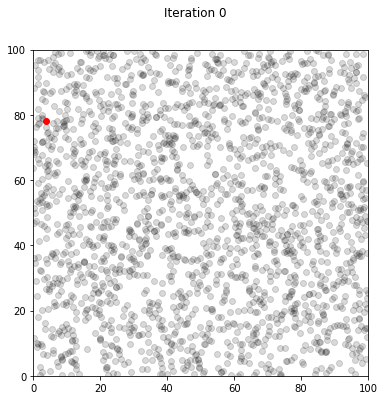


Iteration 1


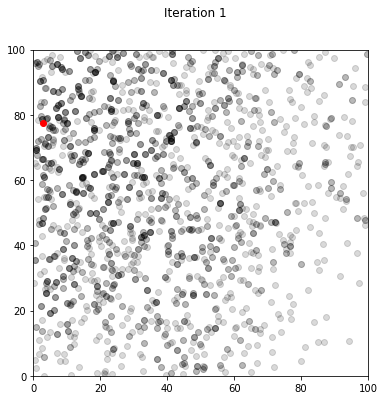


Iteration 2


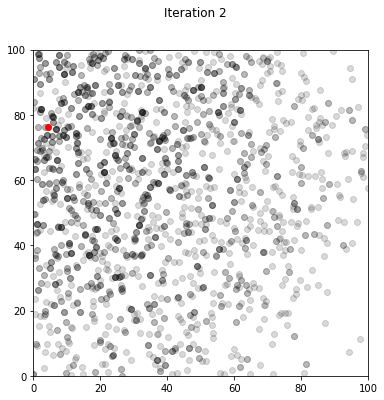


Iteration 3


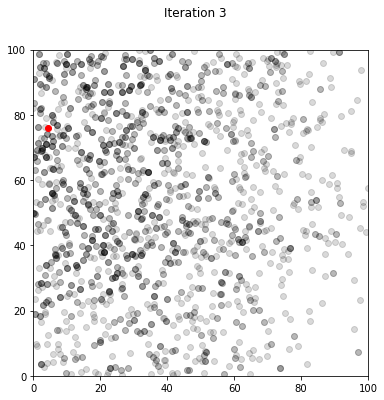


Iteration 4


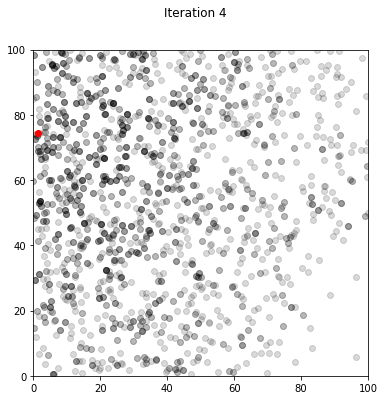


Iteration 5


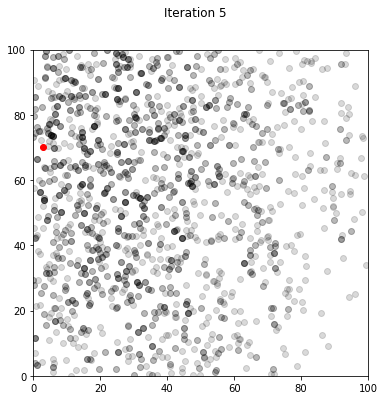


Iteration 6


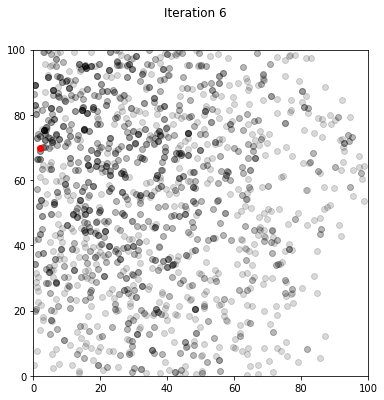


Iteration 7


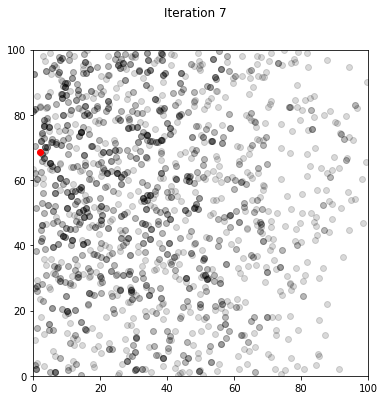


Iteration 8


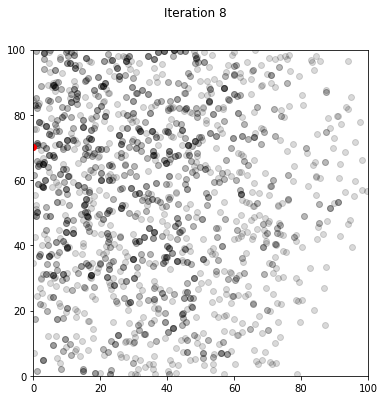


Iteration 9


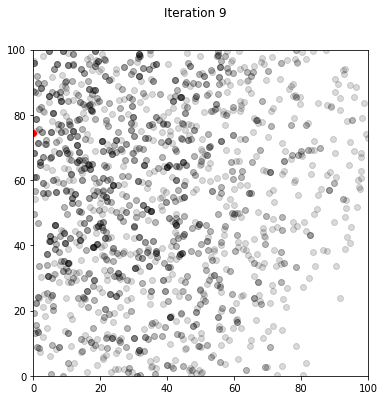


Iteration 10


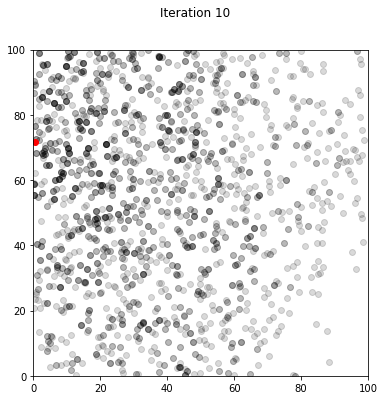


Iteration 11


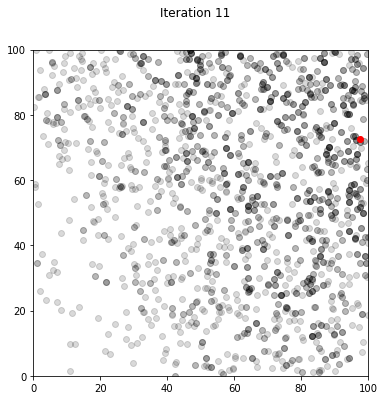


Iteration 12


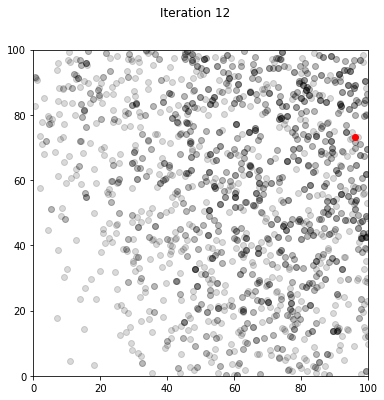


Iteration 13


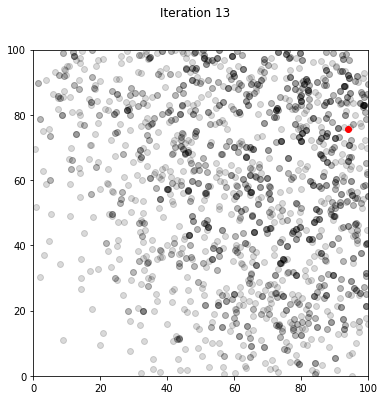


Iteration 14


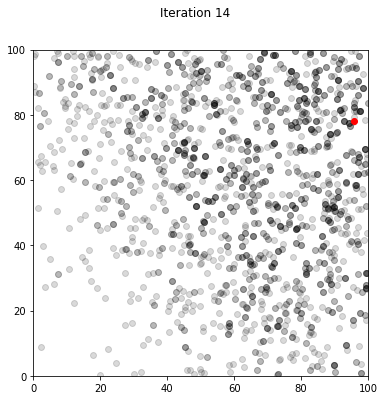


Iteration 15


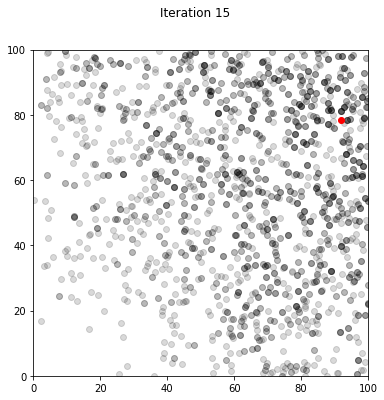


Iteration 16


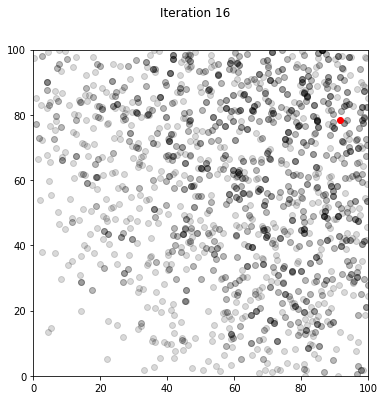


Iteration 17


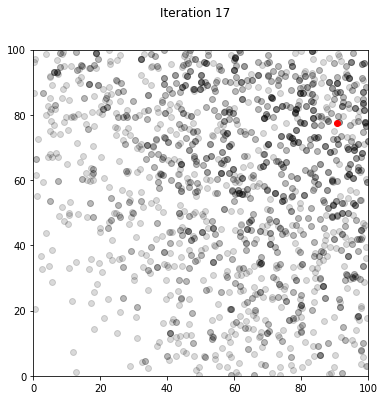


Iteration 18


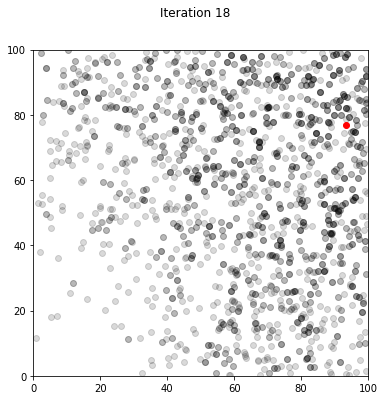


Iteration 19


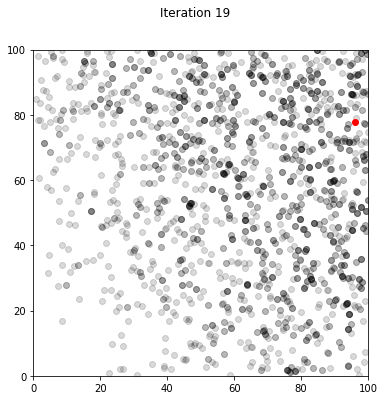


Iteration 20


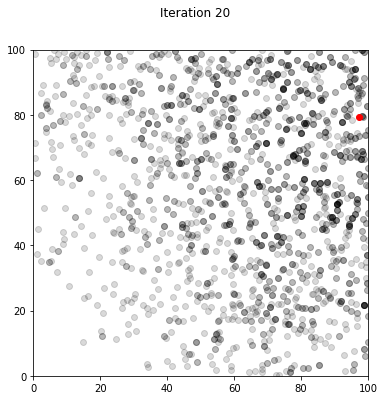


Iteration 21


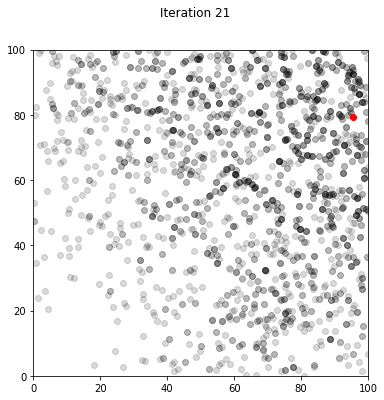


Iteration 22


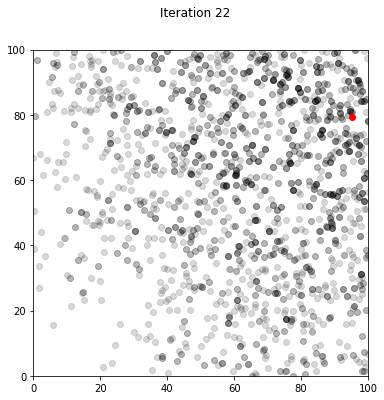


Iteration 23


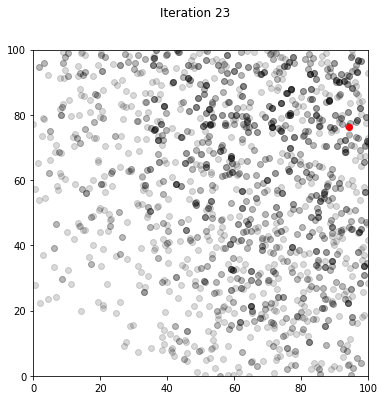


Iteration 24


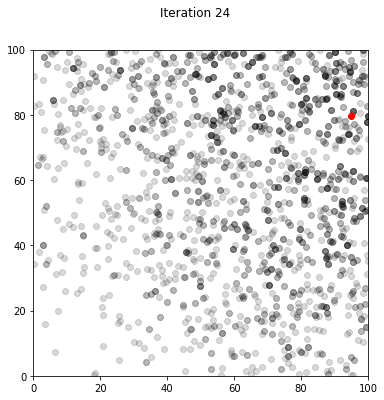


Iteration 25


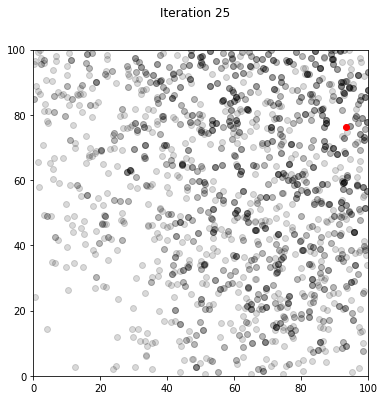


Iteration 26


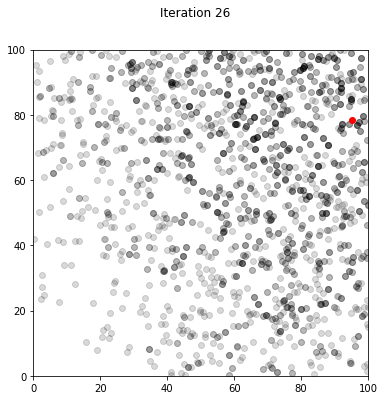


Iteration 27


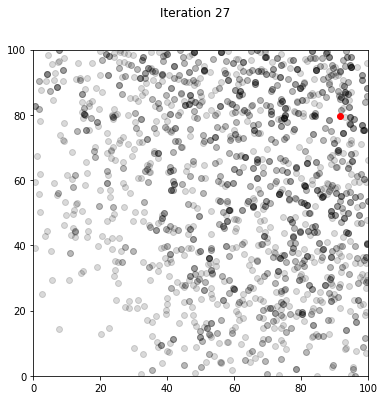


Iteration 28


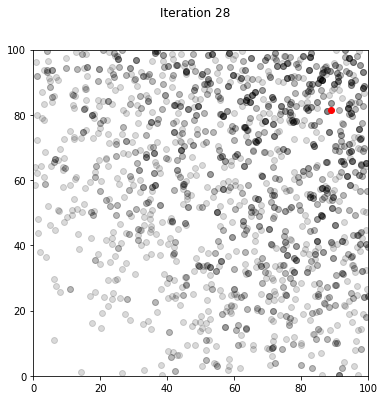


Iteration 29


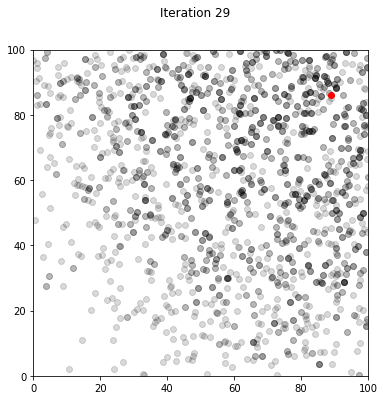


Iteration 30


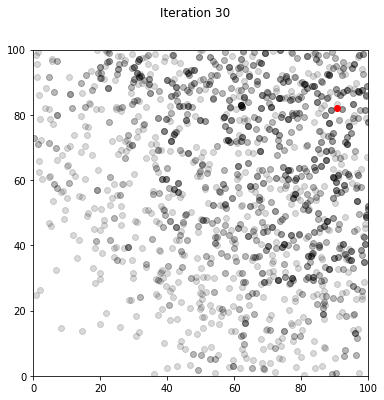


Iteration 31


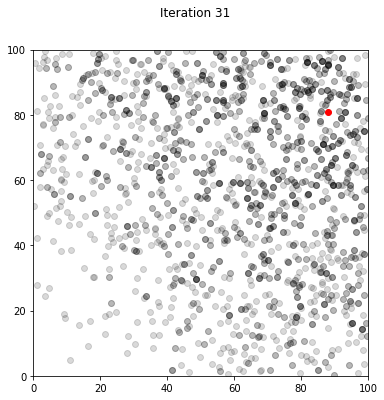


Iteration 32


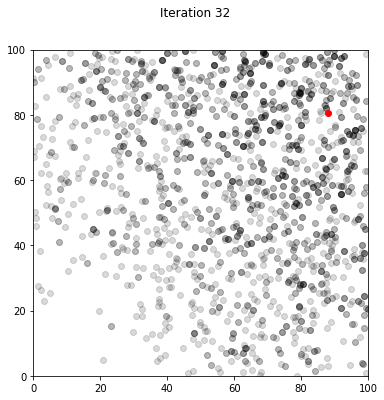


Iteration 33


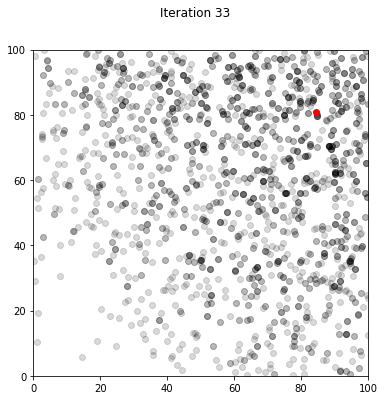


Iteration 34


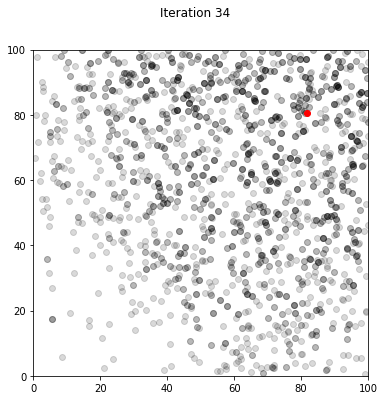


Iteration 35


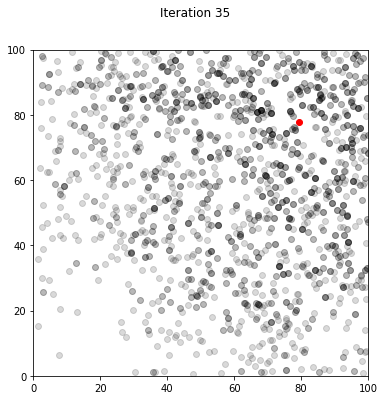


Iteration 36


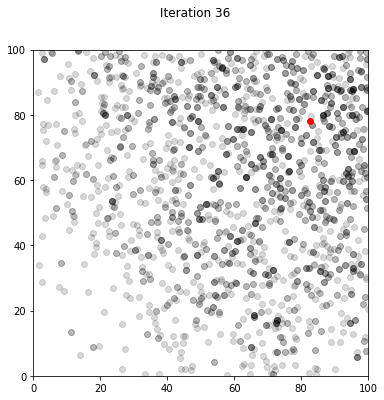


Iteration 37


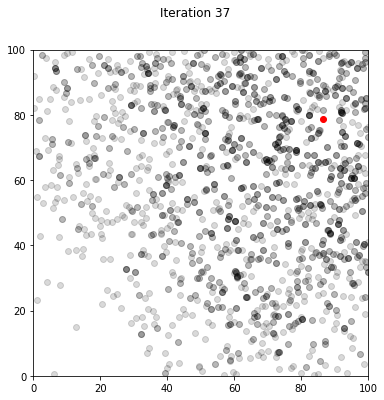


Iteration 38


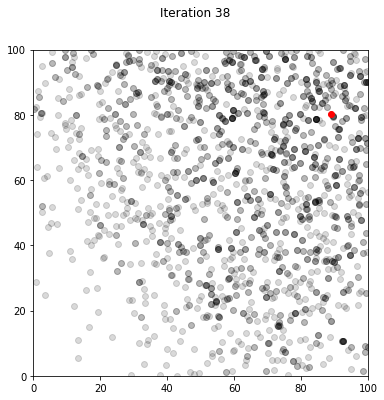


Iteration 39


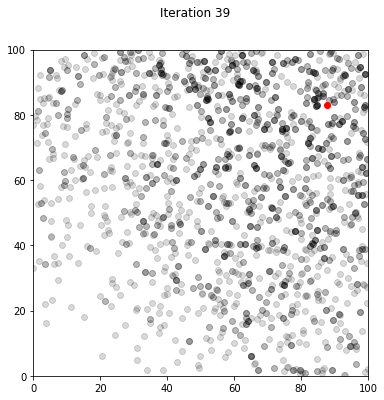


Iteration 40


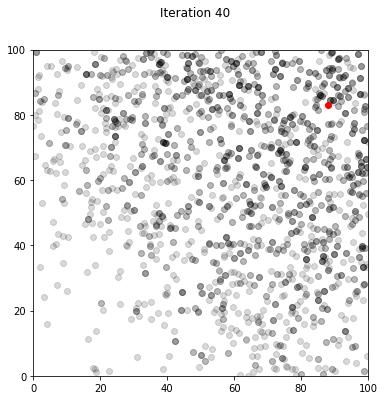


Iteration 41


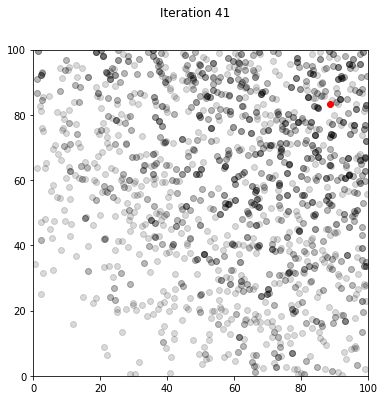


Iteration 42


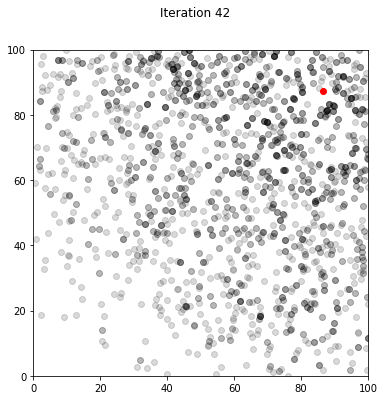


Iteration 43


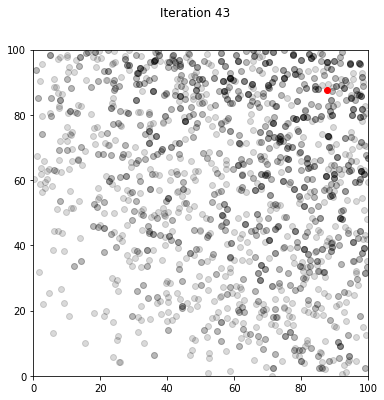


Iteration 44


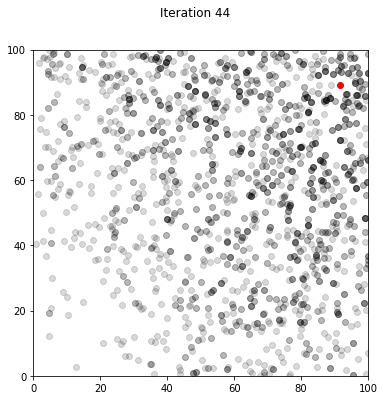


Iteration 45


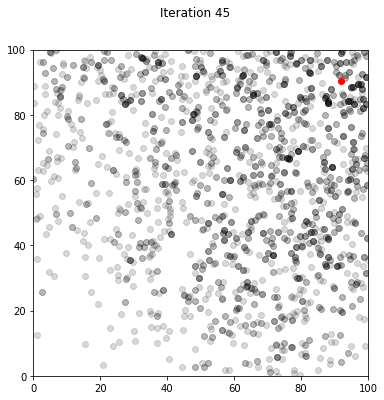


Iteration 46


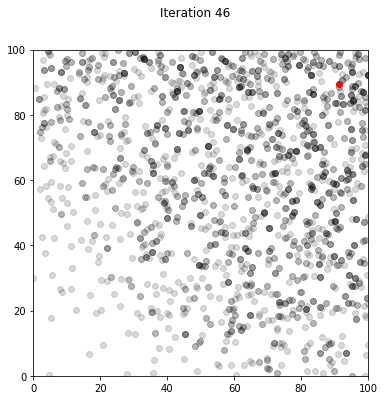


Iteration 47


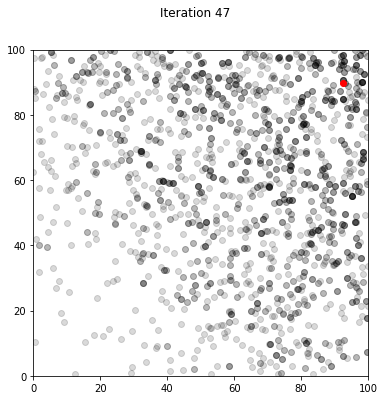


Iteration 48


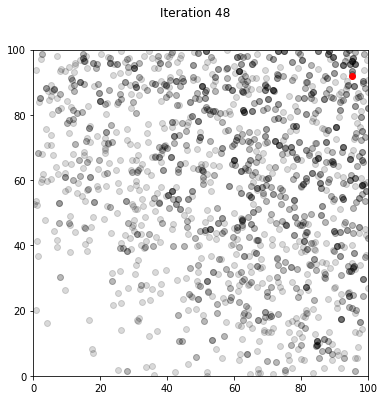


Iteration 49


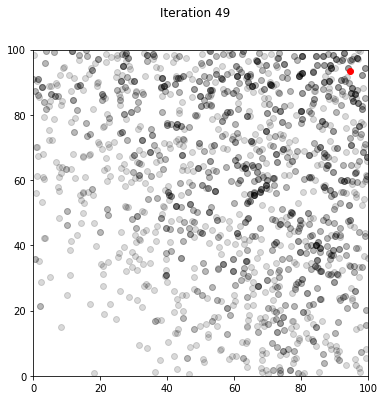


Iteration 50


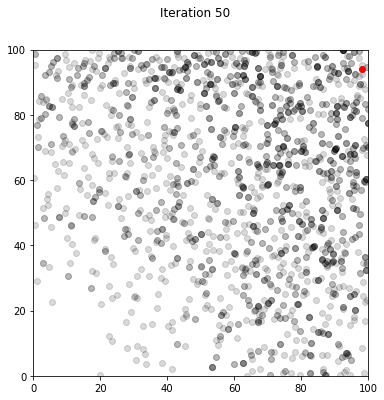

In [1]:
# -*- coding: utf-8 -*-

'''
This code is based on particle filter research includning, particularly, these two articles:
    * Fox, D., Burgard, W., Dellaert, F., & Thrun, S. (1999). Monte carlo localization: Efficient position 
      estimation for mobile robots. AAAI/IAAI, 1999(343-349), 2-2.
    * F. Dellaert, D. Fox, W. Burgard and S. Thrun, "Monte Carlo localization for mobile robots," 
      Proceedings 1999 IEEE International Conference on Robotics and Automation (Cat. No.99CH36288C), 
      1999, pp. 1322-1328 vol.2, doi: 10.1109/ROBOT.1999.772544.
    
Robots and particles derived from the robot class have these features:
    * Constant noise in movement distance and heading expressed as a percentage 
      of the nominal movement distance and direction, respectively
    * Constant noise in sensing distance to the navigation features as a constant 
      percentage of the domain dimension
    * A copy method to permit avoidance of alaising
    * In-place movement: robot x and y coordinates are updated in place rather than needing to 
      instantiate a new robot
    
Distance to navigation features is computed as the Euclidean distance.

Resampling weights for particles are computed via rank of sum of squared differences in distances to navigation
  features robot versus particles

'''

from math import *
import random
import matplotlib.pyplot as plt
import numpy as np

nav_features  = [[10.0, 10.0], [80.0, 90.0], [20.0, 70.0], [90.0, 20.0]]
domain_size = 100.0

class robot:
    ''' Initialize robot with random location/orientation and movement & sensing noise '''
    def __init__(self, forward_noise, turn_noise, sense_noise):
        self.x = random.random() * domain_size
        self.y = random.random() * domain_size
        self.heading = random.random() * 2.0 * pi
        self.forward_noise = float(forward_noise);
        self.turn_noise    = float(turn_noise);
        self.sense_noise   = float(sense_noise);
    
    ''' Measure distance to navigation features, with noise '''
    def sense(self):
        Z = []
        for i in range(len(nav_features)):
            dist = sqrt((self.x - nav_features[i][0]) ** 2 + (self.y - nav_features[i][1]) ** 2)
            dist += (random.random() - 1) * domain_size * self.sense_noise 
            Z.append(dist)
        return Z
    
    ''' Execute move and change location and orientation in-place '''
    def move(self, forward, delta_heading):
        # Update heading with noise
        self.heading = (self.heading + float(delta_heading) * (1 + random.random() - 1) * self.turn_noise) % 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) * (1 + (random.random() - 1) * self.forward_noise) 
        self.x = (self.x + (cos(self.heading) * dist)) % domain_size
        self.y = (self.y + (sin(self.heading) * dist)) % domain_size
    
    ''' Compute sum of squared differences between robot and particle distances to navigation features '''
    def dist_measure(self, robot_meas):
        dist = 0.0;
        me_Z = self.sense()
        for i in range(len(nav_features)):
            dist += (me_Z[i] - robot_meas[i]) ** 2
        return dist 
    
    def copy(self):
        myrobot = robot(self.forward_noise, self.turn_noise, self.sense_noise)
        myrobot.x = self.x
        myrobot.y = self.y
        myrobot.heading = self.heading
        return myrobot
        
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.heading))

def compute_prob(particle_weights):
    ranks = np.empty((len(particle_weights),))
    ranks[np.argsort(-np.array(particle_weights))] = np.arange(len(particle_weights))
    ranks += 1
    w = len(particle_weights) * (len(particle_weights) + 1) / 2 
    return ranks / w
        
    
def plot_domain(t, robot, particles):
    fig,ax = plt.subplots()
    ax.scatter([x.x for x in particles], [x.y for x in particles], c='k', alpha=0.15, zorder=0) #
    #ax.plot([myrobot.x], [myrobot.y], marker='o', color='r', markersize=6, zorder=1)
    ax.scatter([robot.x], [robot.y], c='r', zorder=1)
    ax.set_xlim(0,domain_size)
    ax.set_ylim(0,domain_size)
    fig.suptitle('Iteration ' + str(t))
    fig.set_size_inches(6,6)
    plt.show()
    
''' Parameters '''
num_particles = 2000        # Number of particles in filter
num_iterations = 50          # Number of robot moves to make
move_dist = 5.0  # magnitude of random movement 
move_heading = 0.5 # magnitude of random turn direction
noise_args = (0.05, 0.05, 0.00005)  # noise arguments for movement magnitude, movement direction, and sensing distance to navigation features

''' Create robot to be localized '''
'''   The arguments define, in sequence, the noise in movement magnitude, movement direction, and
      noise is sensing.  The particles used to estimate the robot's position should have the same 
      noise parameters '''
myrobot = robot(*noise_args)

''' Create collection of N particles '''
p = [robot(*noise_args) for i in range(num_particles)]

''' Plot initial position of robot and particles '''
plot_domain(0, myrobot, p)

''' Repeat sense and move T times '''

for t in range(1, num_iterations + 1):
    
    ''' Set move arguments for each iteration for both the robot and particles: (move_magnitude, move_direction) '''
    '''   - We create this tuple so that it can be used to move the robot and each of the particles in the same
            (intended) direction '''
    move_args = (move_dist*random.random(), move_heading*random.random())
    
    ''' Move robot and sense new position: remember there is noise in movement and positiion sensing '''
    ''' Note that the asterisk operator is used to unpack the tuple arguments '''
    myrobot.move(*move_args)
    myrobot_features_dist = myrobot.sense()

    ''' Move all particles by same magnitude and direction as robot moved '''
    ''' Use the variable p for the collection of particles.  It should be a list of "robot" objects '''
    # put your code here
    for i in p:
        i.move(*move_args)
        #i_features_dist = i.sense()
    ''' Compute squared sum of distance differences between robot distances to navigation features and particle distances to navigation features 
        for each particle 
         - Use the variable d to represent a list of distances for each particle 
         - Recall that the variable Z contains the distances of the robot to the 4 navigation features 
         - the dist_measure() function is useful here '''
    # put your code here
    d = []
    for i in p:
        d.append(myrobot.dist_measure(i.sense()))
        #d.append(i.dist_measure(myrobot_features_dist))
    ''' Then, compute the probability of selection using ranks:  
          - The compute_prob() function does this for you '''
    d = compute_prob(d)
    
    ''' Resample new population of particles from current population 
          - When finished, the new population should be a list of "robot" objects in the variable p 
          - Be careful of aliasing '''
           
    # put your code here
    p_list = []
    cum_sum = np.cumsum(d)
    i = 0
    def selection(urv, cum_sum):
        for i in range(len(cum_sum)):
            if urv < cum_sum[i]:
                return i
    
    for i in range(len(p)):
        URV = np.random.random()
        for i in range(len(cum_sum)):
            if URV < cum_sum[i]:
                p_list.append(p[i].copy())
                break
    #p = plist
    #print(p_list)
    ''' Print iteration number and plot robot and particles '''
    print('\nIteration %d' % (t,))
    plot_domain(t, myrobot, p_list)